# Importy i wczytywanie danych + Profile Report

In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas_profiling import ProfileReport
from sklearn.preprocessing import LabelEncoder
%matplotlib inline


In [59]:
initial_df = pd.read_csv('insurance.csv')


In [60]:
profile = ProfileReport(initial_df)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# EDA

In [61]:
initial_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [62]:
initial_df.shape

(1338, 7)

In [63]:
initial_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [64]:
initial_df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

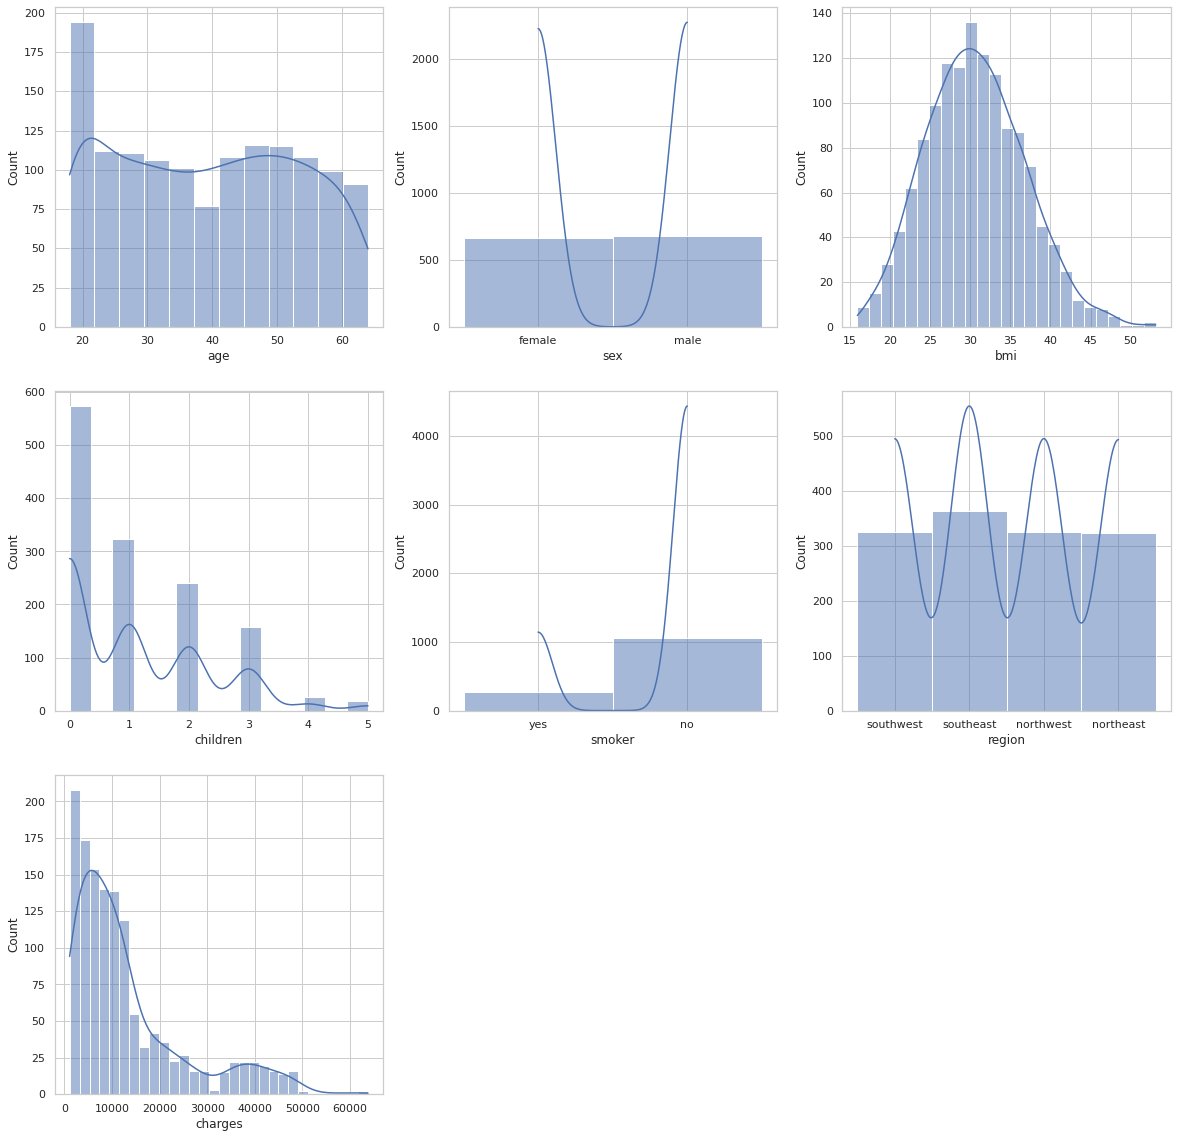

In [65]:
# histogram with kde
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(20, 20))
fig.delaxes(axes[2][1])
fig.delaxes(axes[2][2])

for i, ax in zip(range(7), axes.flat):
    sns.histplot(data=initial_df, x=initial_df.columns[i], kde=True, ax=ax)
plt.show()

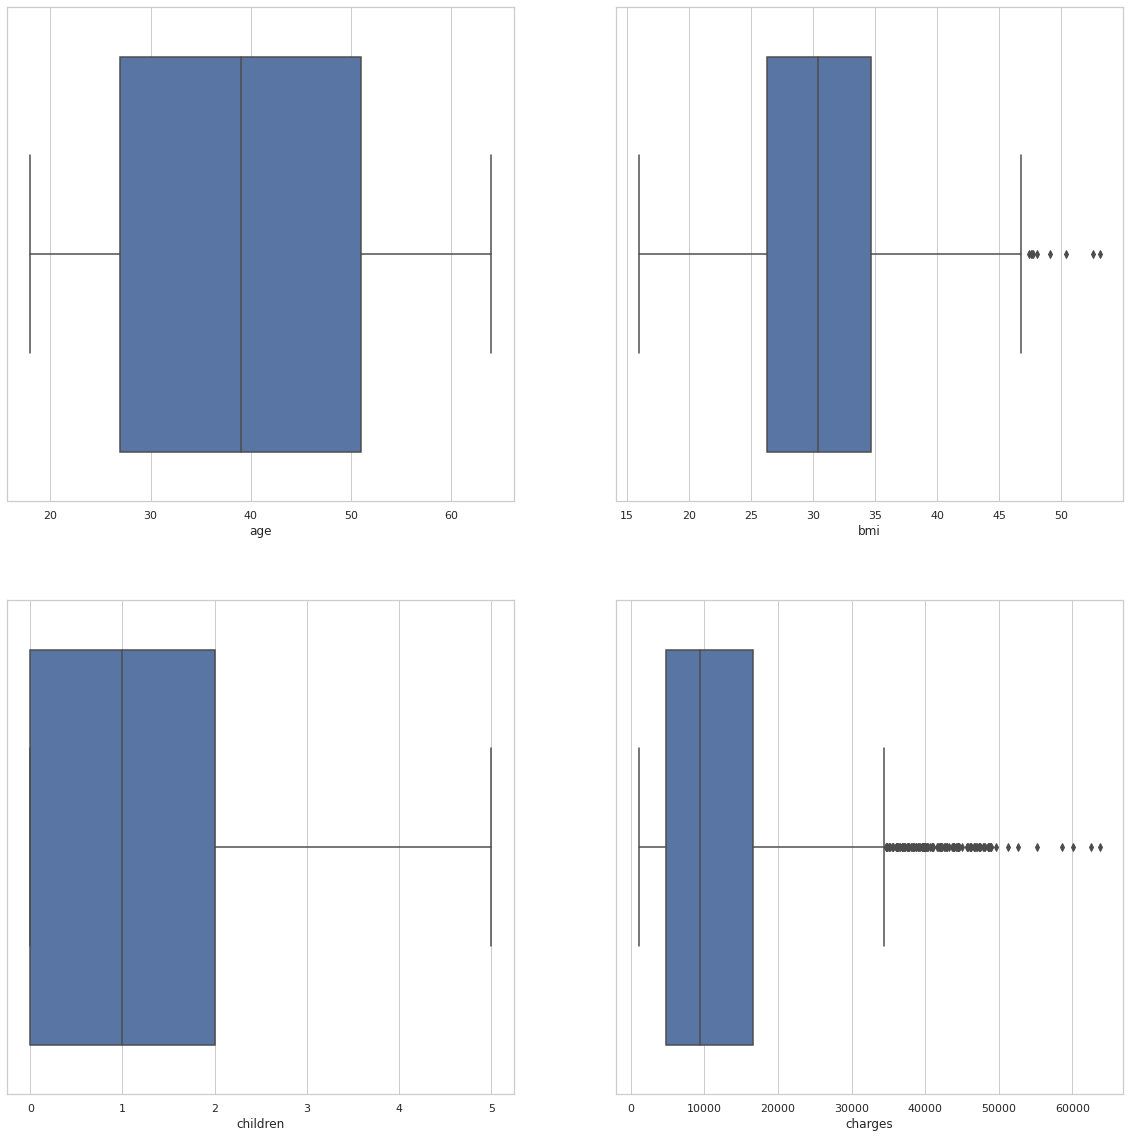

In [66]:
# boxplots
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
for i, ax in zip(range(4), axes.flat):
    sns.boxplot(x=initial_df[['age', 'bmi', 'children', 'charges']].iloc[:, i], ax=ax)
plt.show()

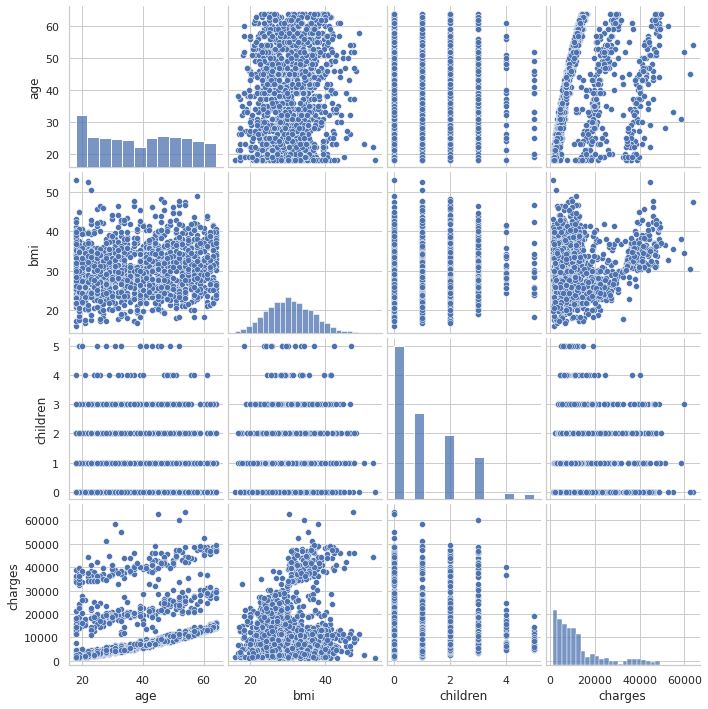

In [67]:
sns.pairplot(initial_df)

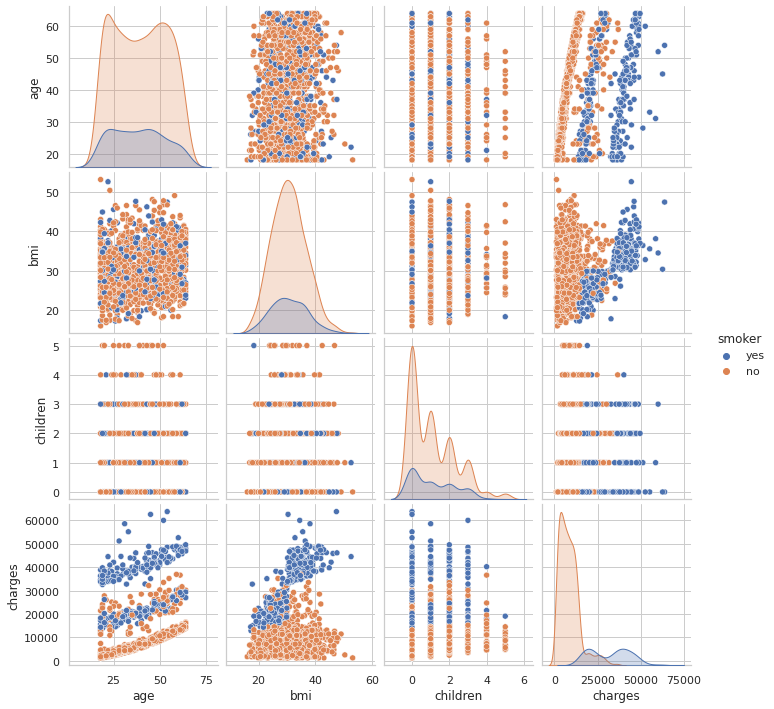

In [68]:
sns.pairplot(initial_df, hue='smoker')

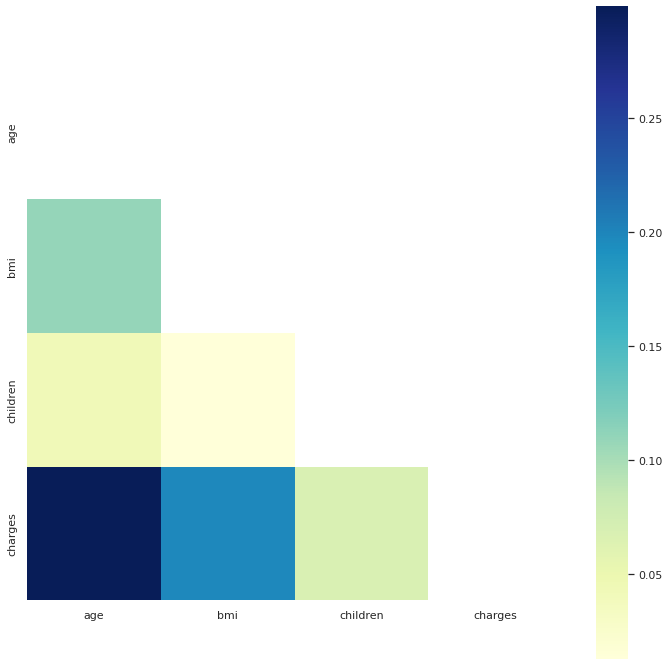

In [69]:
corr = np.corrcoef(np.random.randn(4, 200))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(12, 12))
sns.heatmap(initial_df.corr(), cmap='YlGnBu', mask=mask, square=True)
plt.show()

# Preprocessing

In [70]:
# one hot encoding
df = pd.get_dummies(initial_df, drop_first=True)
# dodanie kategorii otyły (w USA wg jakiegoś medycznego instytu jest po prostu powyżej 30
df["obese"] = df["bmi"].apply(lambda x: 1 if x >= 30 else 0)
# dodanie kategorii otyły i palący
df["obese_smoker"] = df[["obese", "smoker_yes"]].apply(
    lambda x: 1 if (x["obese"] == 1) & (x["smoker_yes"] == 1) else 0, axis=1
)

# EDA cd i szukanie outlierów

<AxesSubplot:>

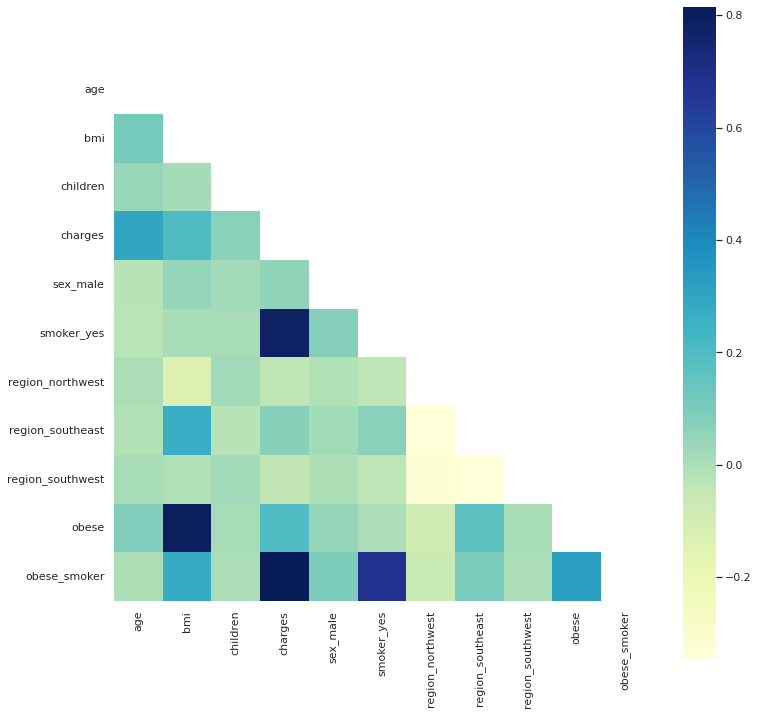

In [71]:
# nowa mapa korelacji
corr = np.corrcoef(np.random.randn(11, 200))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(12, 12))
sns.heatmap(df.corr(), cmap="YlGnBu", mask=mask, square=True)

In [122]:
df

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,obese,obese_smoker
0,19,27.900,0,16884.92400,0,1,0,0,1,0,0
1,18,33.770,1,1725.55230,1,0,0,1,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,1,0,1,0,0,1,0
1334,18,31.920,0,2205.98080,0,0,0,0,0,1,0
1335,18,36.850,0,1629.83350,0,0,0,1,0,1,0
1336,21,25.800,0,2007.94500,0,0,0,0,1,0,0


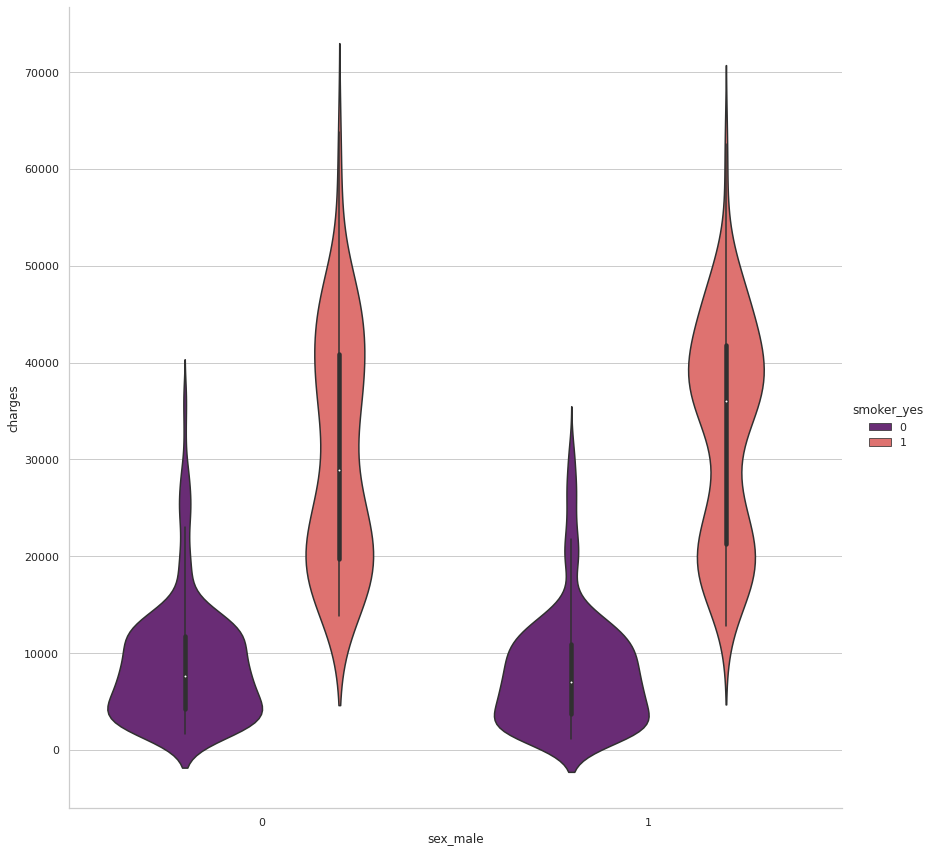

In [142]:

sns.catplot(x="sex_male", y="charges", hue="smoker_yes",
            kind="violin", data=df, palette = 'magma',height=12, aspect=1)


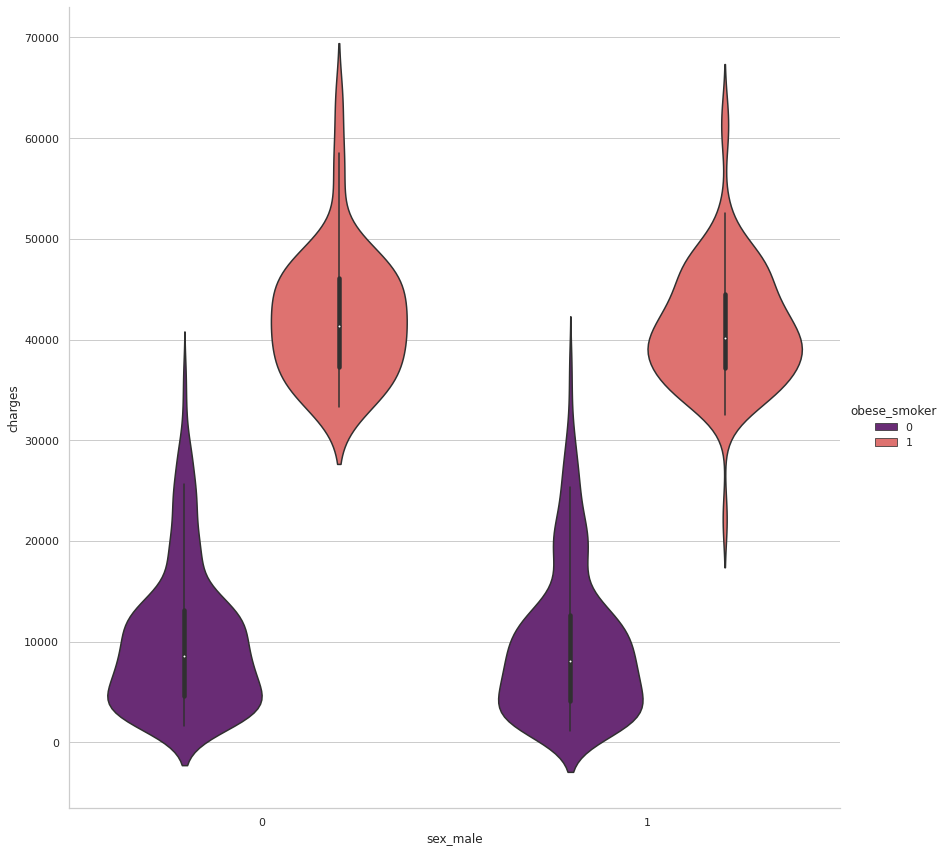

In [143]:
sns.catplot(x="sex_male", y="charges", hue="obese_smoker",
            kind="violin", data=df, palette = 'magma',height=12, aspect=1)


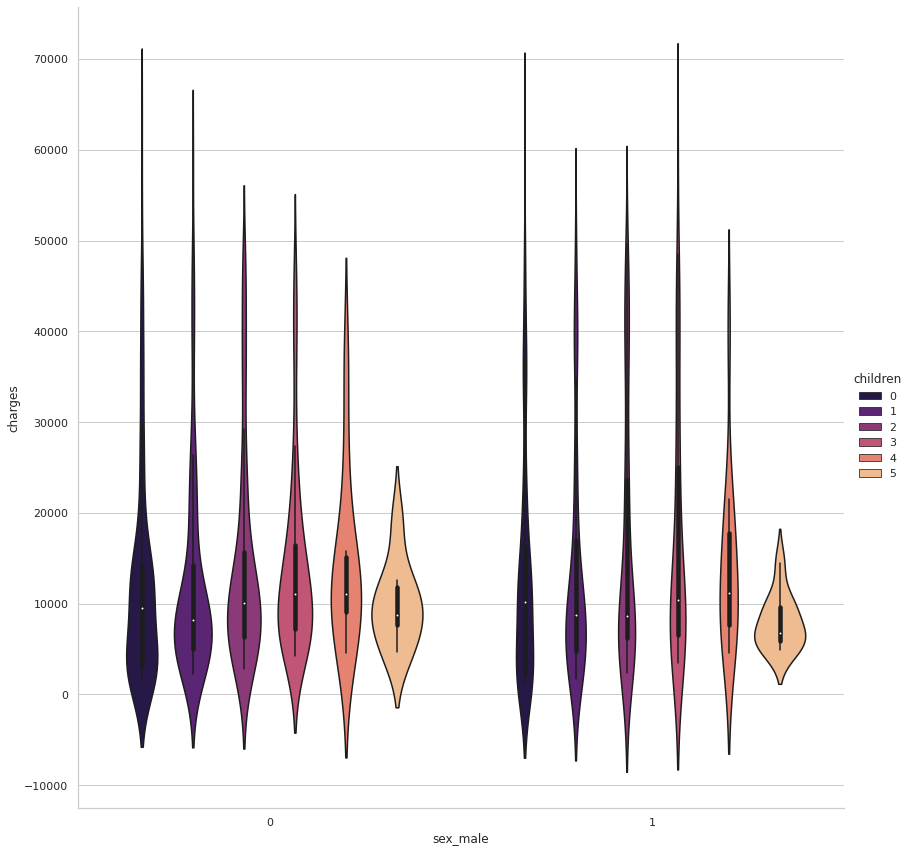

In [144]:
sns.catplot(x="sex_male", y="charges", hue="children",
            kind="violin", data=df, palette = 'magma',height=12, aspect=1)


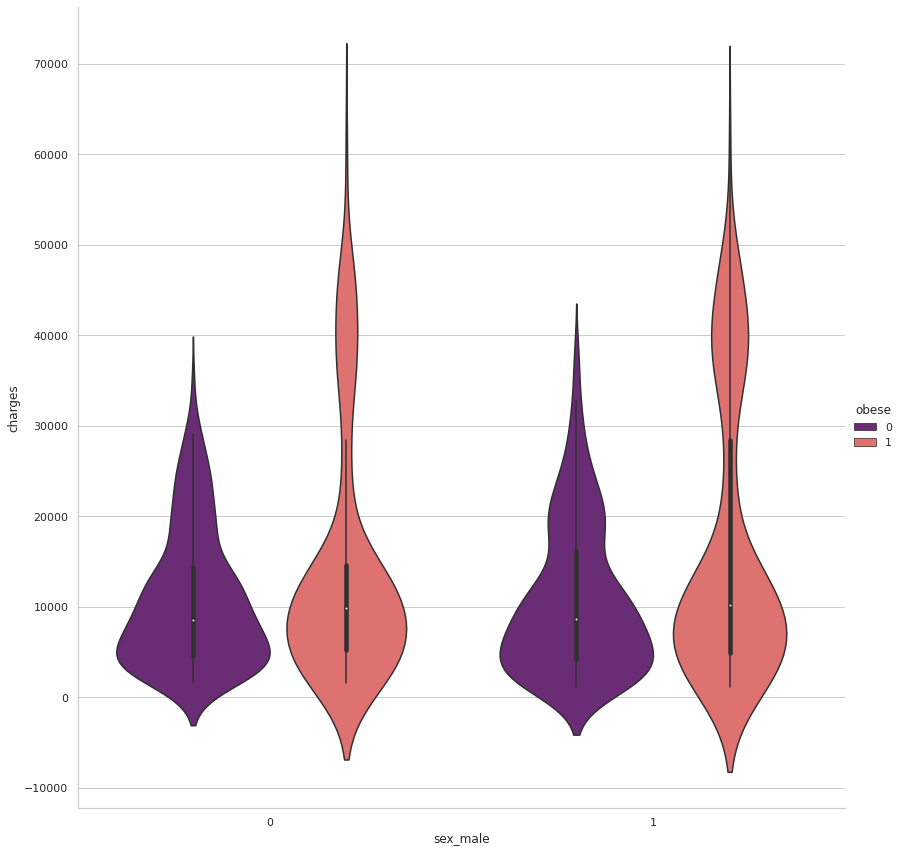

In [145]:
sns.catplot(x="sex_male", y="charges", hue="obese",
            kind="violin", data=df, palette = 'magma',height=12, aspect=1)


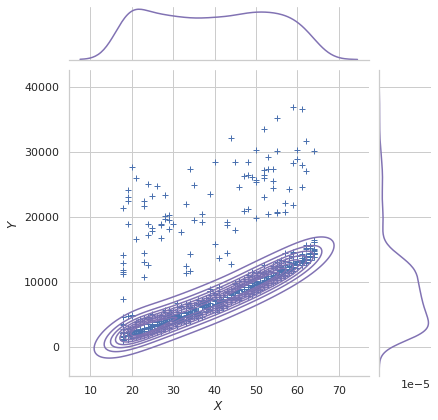

In [166]:
g = sns.jointplot(x="age", y="charges", data = df[(df.smoker_yes == 0)],kind="kde", color="m")
g.plot_joint(plt.scatter, s=30, linewidth=1, marker='+')
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$")
ax.set_title('Distribution of charges and age for non-smokers')
plt.show()

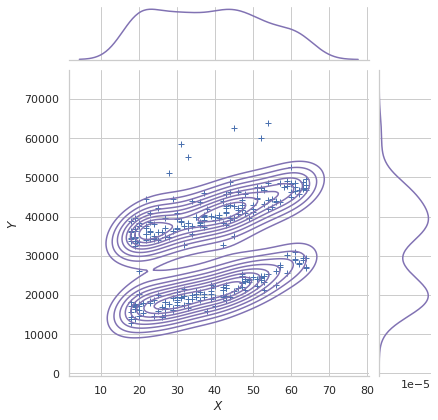

In [162]:
g = sns.jointplot(x="age", y="charges", data = df[(df.smoker_yes == 1)],kind="kde", color="m")
g.plot_joint(plt.scatter, s=30, linewidth=1, marker='+')
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$")
ax.set_title('Distribution of charges and age for non-smokers')
plt.show()

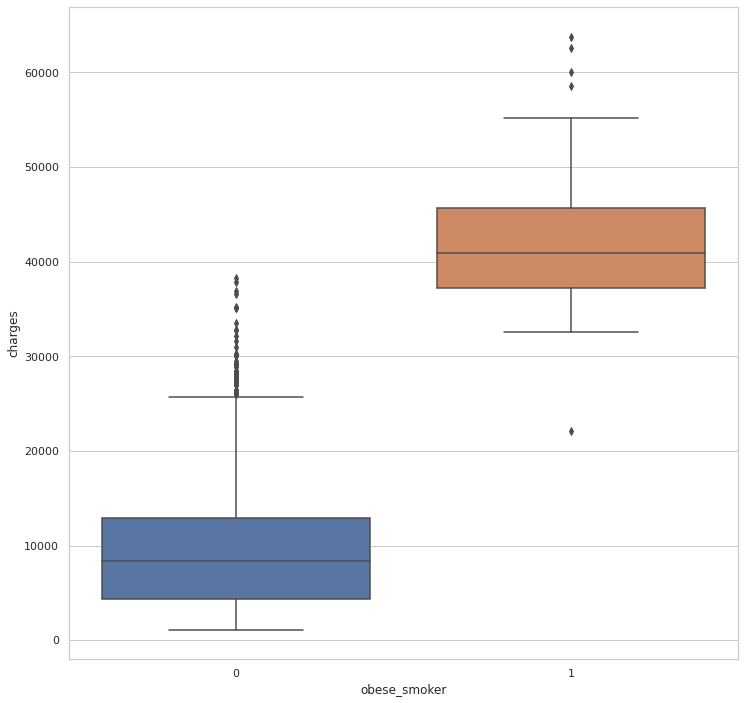

In [138]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(y=df["charges"], x=df["obese_smoker"], whis=1.5)

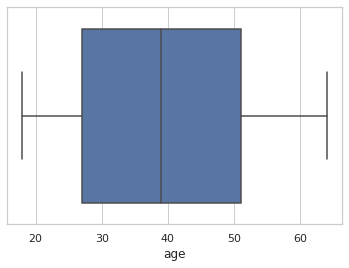

In [73]:
sns.set_theme(style='whitegrid')
ax = sns.boxplot(x=initial_df['age'])

# Podział na zbiór treningowy i testowy

In [192]:
from sklearn.model_selection import train_test_split

X = df.drop('charges', axis=1)
y = df['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=X.smoker_yes)
X_train.smoker_yes.describe()

count    936.000000
mean       0.205128
std        0.404011
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: smoker_yes, dtype: float64

# Analiza PCA

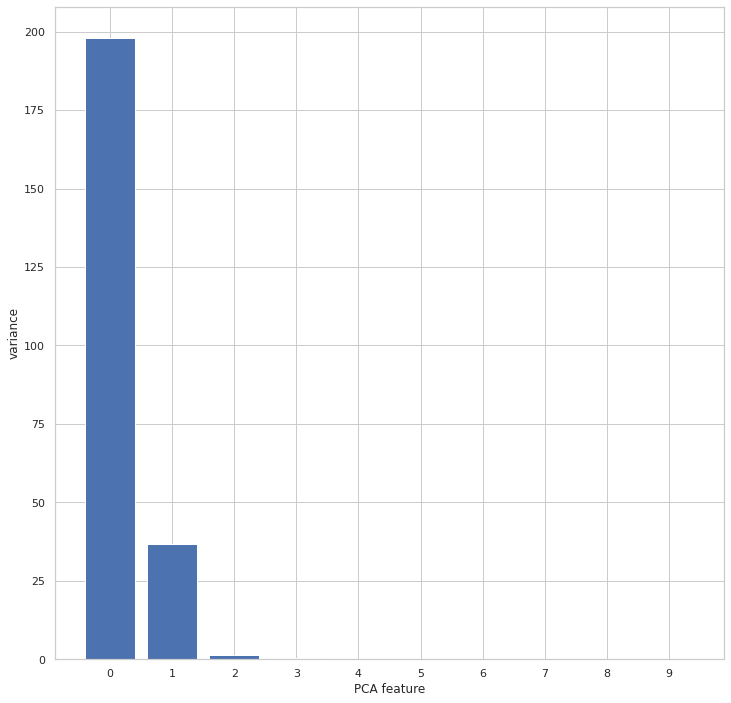

In [193]:
# PCA without standarization - just for comparision
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
pca = PCA(random_state=0)


# Fit the pipeline to 'samples'
pca.fit(X)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

Percentage of variance by component[0.2250378  0.15096013 0.13269335 0.12225973 0.10077208 0.09923312
 0.09291747 0.03209376 0.02576109 0.01827147]


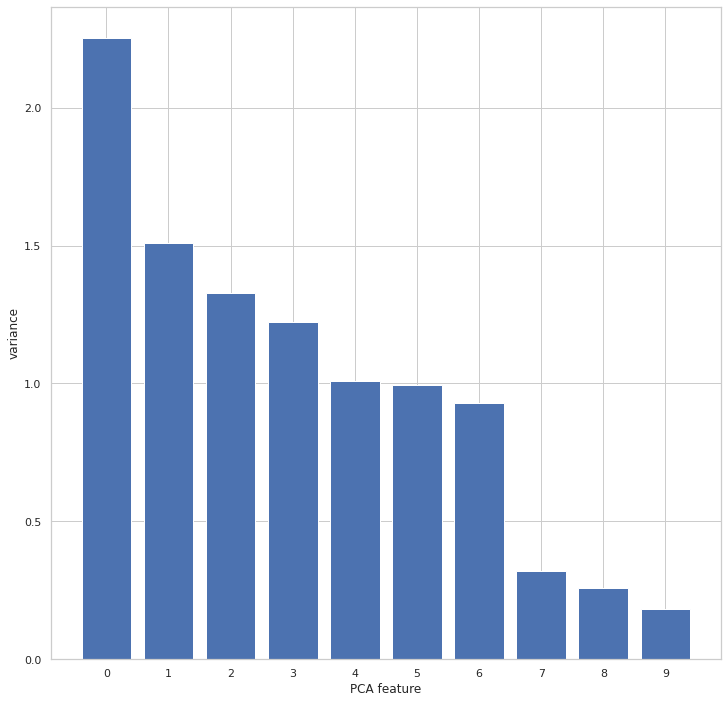

In [194]:
# standarization and PCA
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(ss, pca)
pipeline.fit(X)
print(f'Percentage of variance by component{pca.explained_variance_ratio_}')
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

# Wstępne modelowanie

* Regresja liniowa

In [195]:
from sklearn.linear_model import LinearRegression
lin_reg=LinearRegression()
lin_reg.fit(X_train, y_train)
lin_reg.score(X_test, y_test)

0.8686052119722945

In [196]:
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(ss, lin_reg)
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.8686052119722945

In [197]:
from sklearn.model_selection import cross_val_score

cross_val_score(lin_reg, X_train, y_train, cv=10)



array([0.84758495, 0.71933733, 0.81970025, 0.94939516, 0.7505604 ,
       0.93292591, 0.88276823, 0.85953485, 0.86118202, 0.84958729])

* RFC and features importances

0.861948623199307


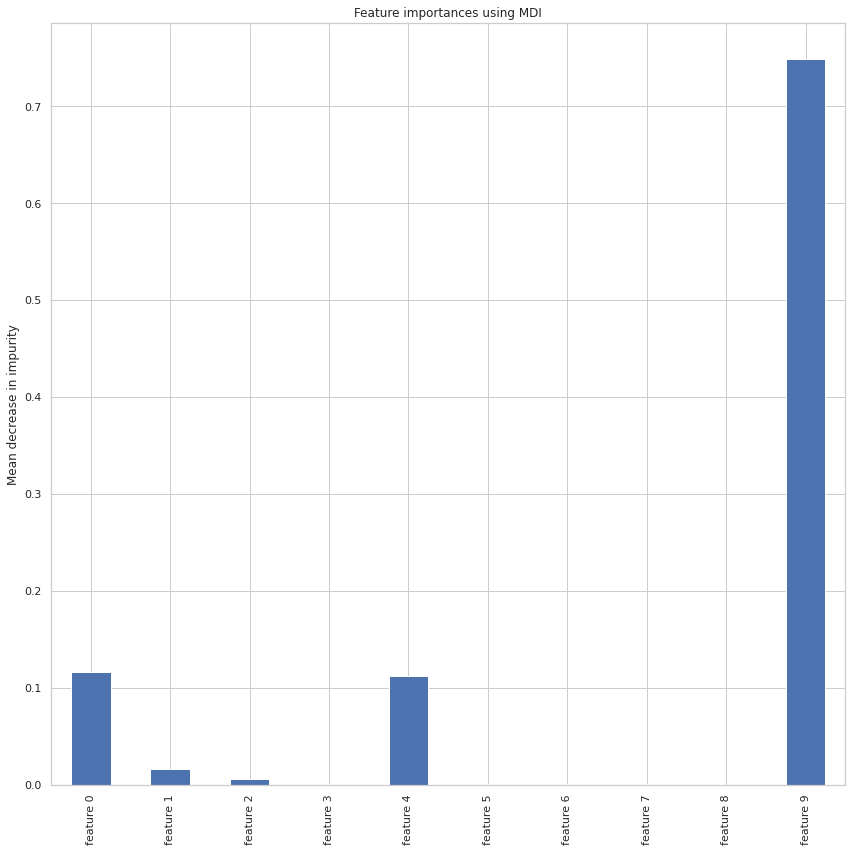

In [198]:
#rfc
from sklearn.ensemble import RandomForestRegressor
rfc = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=1, n_jobs=-1)

rfc.fit(X_train, y_train)
print(rfc.score(X_test, y_test))
feature_names = [f"feature {i}" for i in range(X.shape[1])]
importances = rfc.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
std = np.std([rfc.feature_importances_ for tree in rfc.estimators_], axis=0)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

* KNeighborsRegressor

In [199]:
# no standarization, no PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

knn_reg = KNeighborsRegressor()
param_grid = {
    'n_neighbors': list(range(4, 41, 4)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
}
search = GridSearchCV(knn_reg, param_grid, cv=10, n_jobs=-1)
search.fit(X_train, y_train)
print('Best parameter (CV score=%0.3f):' % search.best_score_)
print(search.best_params_)
print(search.score(X_test, y_test))

Best parameter (CV score=0.510):
{'n_neighbors': 8, 'p': 1, 'weights': 'distance'}
0.47034790381100455


In [200]:
# after Standarization
pipeline_ss = Pipeline(steps=[('ss', ss), ('knn', knn_reg)])
param_grid_ss = {
    'knn__n_neighbors': list(range(4, 41, 4)),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2],
}
search_ss = GridSearchCV(pipeline_ss, param_grid_ss, cv=10, n_jobs=-1)
search_ss.fit(X_train, y_train)
print('Best parameter (CV score=%0.3f):' % search_ss.best_score_)
print(search_ss.best_params_)
print(search_ss.score(X_test, y_test))

Best parameter (CV score=0.825):
{'knn__n_neighbors': 8, 'knn__p': 2, 'knn__weights': 'distance'}
0.8332357880683864


In [201]:
# after standarization and PCA
pipeline_pca = Pipeline(steps=[('ss', ss), ('pca', pca), ('knn', knn_reg)])
param_grid_pca = {
    'pca__n_components': list(range(2, 9)),
    'knn__n_neighbors': list(range(4, 41, 4)),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2],
}
search_pca = GridSearchCV(pipeline_pca, param_grid_pca, cv=5, n_jobs=-1)
search_pca.fit(X_train, y_train)
print('Best parameter (CV score=%0.3f):' % search_pca.best_score_)
print(search_pca.best_params_)
print(search_pca.score(X_test, y_test))

Best parameter (CV score=0.820):
{'knn__n_neighbors': 8, 'knn__p': 1, 'knn__weights': 'distance', 'pca__n_components': 7}
0.8299921192868389


* xgboost bez GridSearch

In [202]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import xgboost as xgb
mm=MinMaxScaler()
ss=StandardScaler()
pca=PCA(n_components=0.95)
xgboost = xgb.XGBRegressor(max_depth = 3, n_estimators=50, learning_rate =.2)
pipeline = make_pipeline(ss, xgboost) #pca?
pipeline.fit(X_train, y_train)
pipeline.score(X_test,y_test)

0.8639550140833409

# Alternatywne modele / do dalszych rozważań

* ElasticNet

In [203]:
# after standarization and PCA
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(random_state=0)

pipeline_pca = Pipeline(steps=[('ss', ss), ('pca', pca), ('elastic_net', elastic_net)])
param_grid_pca = {'pca__n_components': list(range(2, 9))}
search_pca = GridSearchCV(pipeline_pca, param_grid_pca, cv=5, n_jobs=-1)
search_pca.fit(X_train, y_train)
print('Best parameter (CV score=%0.3f):' % search_pca.best_score_)
print(search_pca.best_params_)
print(search_pca.score(X_test, y_test))

Best parameter (CV score=0.799):
{'pca__n_components': 8}
0.8156301829013208


* Stacking Regressor

In [204]:
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

final_estimator=LassoCV()

estimators = [
    (
        'RFC',
        RandomForestRegressor(n_estimators=100, max_depth=5, random_state=1, n_jobs=-1),
    ),
    ('GBR', GradientBoostingRegressor()),
    ('Ada', AdaBoostRegressor()),
    ('XGB', xgboost),
]

reg = StackingRegressor(estimators=estimators, cv=10, final_estimator=final_estimator)
pipeline3 = make_pipeline(ss, reg)
reg.fit(X_train, y_train)
print(reg.score(X_test, y_test))

0.8648715152541446


# Inne (obróbka danych, features engineering)

* Przetestowanie podziału na dwa datasety (palący i niepalący)

In [205]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as MSE


X2 = df[df['smoker_yes'] == 0].drop('charges', axis=1)
y2 = df['charges'][df['smoker_yes'] == 0]
# X = df[['age', 'obese_smoker', 'smoker_yes']]
# y = df['charges']
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2, y2, test_size=0.3, random_state=42
)

X3 = df[df['smoker_yes'] == 1].drop('charges', axis=1)
y3 = df['charges'][df['smoker_yes'] == 0]
# X = df[['age', 'obese_smoker', 'smoker_yes']]
# y = df['charges']
X_train3, X_test3, y_train3, y_test3 = train_test_split(
    X, y, test_size=0.3, random_state=42
)
estimators = [
    RandomForestRegressor(n_estimators=100, max_depth=5, random_state=1, n_jobs=-1),
    GradientBoostingRegressor(),
    AdaBoostRegressor(),
    xgboost,
    SVR(kernel='linear'),
    KNeighborsRegressor(),
]
for estimator in estimators:
    pipeline_estimator = make_pipeline(ss, estimator)
    pipeline_estimator.fit(X_train, y_train)
    y_pred = pipeline_estimator.predict(X_test)
    R2 = pipeline_estimator.score(X_test, y_test)
    mse = MSE(y_test, y_pred)
    rmse = mse ** 0.5
    print(
        f' Full df for estimator {estimator.__class__.__name__} Value of R2 = {R2}, MSE={mse}, RMSE={rmse}'
    )
    pipeline_estimator = make_pipeline(ss, estimator)
    pipeline_estimator.fit(X_train2, y_train2)
    y_pred2 = pipeline_estimator.predict(X_test2)
    R2 = pipeline_estimator.score(X_test2, y_test2)
    mse = MSE(y_test2, y_pred2)
    rmse = mse ** 0.5
    print(
        f' Non smokers for estimator {estimator.__class__.__name__} Value of R2 = {R2}, MSE={mse}, RMSE={rmse}'
    )
    pipeline_estimator = make_pipeline(ss, estimator)
    pipeline_estimator.fit(X_train3, y_train3)
    y_pred3 = pipeline_estimator.predict(X_test3)
    R2 = pipeline_estimator.score(X_test3, y_test3)
    mse = MSE(y_test3, y_pred3)
    rmse = mse ** 0.5
    print(
        f' Smokers for estimator {estimator.__class__.__name__} Value of R2 = {R2}, MSE={mse}, RMSE={rmse}'
    )

 Full df for estimator RandomForestRegressor Value of R2 = 0.8618266901063265, MSE=19888334.661113545, RMSE=4459.633915593694
 Non smokers for estimator RandomForestRegressor Value of R2 = 0.42174716775869214, MSE=20020560.162935235, RMSE=4474.434060631046
 Smokers for estimator RandomForestRegressor Value of R2 = 0.8650867229952629, MSE=19781565.86654809, RMSE=4447.647228203704
 Full df for estimator GradientBoostingRegressor Value of R2 = 0.8641840237807041, MSE=19549025.708755, RMSE=4421.428016914332
 Non smokers for estimator GradientBoostingRegressor Value of R2 = 0.3965186299889092, MSE=20894035.276381887, RMSE=4570.999373920531
 Smokers for estimator GradientBoostingRegressor Value of R2 = 0.862498126589142, MSE=20161117.023012787, RMSE=4490.113252804743
 Full df for estimator AdaBoostRegressor Value of R2 = 0.7884240485226006, MSE=30453734.751408063, RMSE=5518.490260153411
 Non smokers for estimator AdaBoostRegressor Value of R2 = 0.2665231422416593, MSE=25394804.38332481, RMSE

* Alternatywny preprocessing i features enginnering (Polynomial)

In [206]:

# dodanie kategorii otyły (w USA wg jakiegoś medycznego instytu jest po prostu powyżej 30
initial_df['bmi_cat'] = pd.cut(x = initial_df['bmi'], bins = [0, 18.5, 24.9, 29.9, 100], labels = ['underweight',
                                                                                  'healthy weight',
                                                                                   'overweight',
                                                                                   'obesity'])

initial_df['age_cat'] = pd.cut(x = initial_df['age'], bins = [0, 35, 56, 100], labels = ['young adult',
                                                                                  'senior adult',
                                                                                   'elder'])




In [207]:
df2 = pd.get_dummies(initial_df)
df2.shape

(1338, 19)

In [208]:
df2["obese_smoker"] = df2[["bmi_cat_obesity", "smoker_yes"]].apply(
    lambda x: 1 if (x["bmi_cat_obesity"] == 1) & (x["smoker_yes"] == 1) else 0, axis=1)


In [209]:
X4 = df2.drop('charges', axis=1)
y = df2['charges']
X4.columns

Index(['age', 'bmi', 'children', 'sex_female', 'sex_male', 'smoker_no',
       'smoker_yes', 'region_northeast', 'region_northwest',
       'region_southeast', 'region_southwest', 'bmi_cat_underweight',
       'bmi_cat_healthy weight', 'bmi_cat_overweight', 'bmi_cat_obesity',
       'age_cat_young adult', 'age_cat_senior adult', 'age_cat_elder',
       'obese_smoker'],
      dtype='object')

In [210]:
from sklearn.preprocessing import PolynomialFeatures
pol_features=PolynomialFeatures(degree=2, interaction_only=True)
X_new =pol_features.fit_transform(X4)
X_new.shape
count=0
for name in pol_features.get_feature_names(X4.columns):
    count+=1
count

/home/mm/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


191

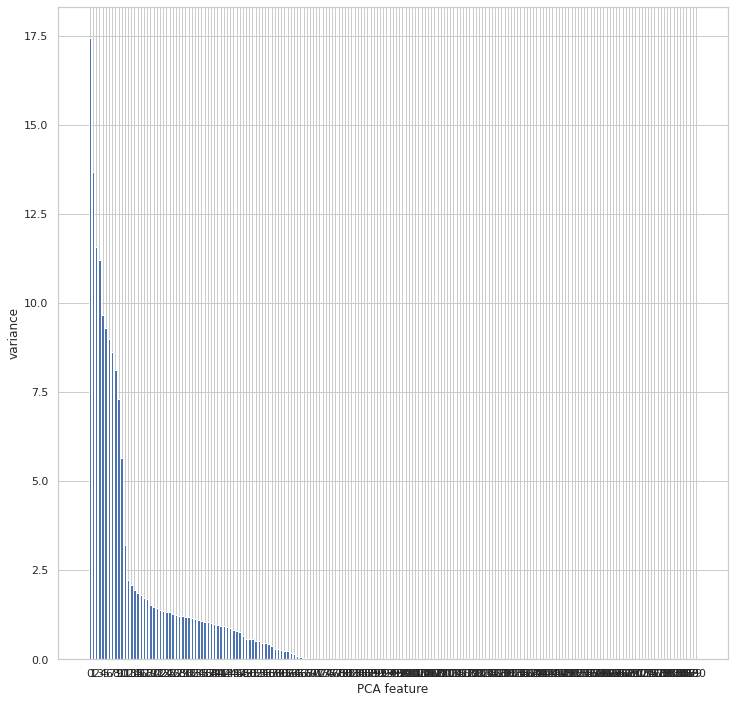

In [211]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
ss=StandardScaler()
pca=PCA()

pipeline = make_pipeline(ss, pca)
pipeline.fit(X_new)
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

In [212]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(
    X_new, y,test_size=0.3, random_state=42)

In [213]:
#rfc
from sklearn.ensemble import RandomForestRegressor
rfc = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=1, n_jobs=-1)

rfc.fit(X_train4, y_train4)
print(rfc.score(X_test4, y_test4))
count2=0
for i in rfc.feature_importances_:
    count2+=1
count2
idx_list=[]
for idx,value in enumerate(rfc.feature_importances_):
    if value>0.01:
        print(idx,value)
        idx_list.append(idx)
idx_list
features_names=pol_features.get_feature_names(X4.columns)
features_list=[]
for idx in idx_list:
    print(features_names[idx])
    features_list.append(features_names[idx])
features_list

0.8682090430619106
1 0.028170458027618184
19 0.029310408342474642
20 0.023494983921848206
24 0.020445274809909562
25 0.017920283032786036
37 0.04863120666231274
42 0.5039605291245609
54 0.10583424755775078
109 0.04592170106957147
110 0.01262975902436999
120 0.05225644941835256
124 0.014965768247635904
184 0.044825468832703545
age
obese_smoker
age bmi
age smoker_no
age smoker_yes
age obese_smoker
bmi smoker_yes
bmi obese_smoker
smoker_no age_cat_young adult
smoker_no age_cat_senior adult
smoker_yes bmi_cat_obesity
smoker_yes obese_smoker
bmi_cat_obesity obese_smoker


/home/mm/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['age',
 'obese_smoker',
 'age bmi',
 'age smoker_no',
 'age smoker_yes',
 'age obese_smoker',
 'bmi smoker_yes',
 'bmi obese_smoker',
 'smoker_no age_cat_young adult',
 'smoker_no age_cat_senior adult',
 'smoker_yes bmi_cat_obesity',
 'smoker_yes obese_smoker',
 'bmi_cat_obesity obese_smoker']

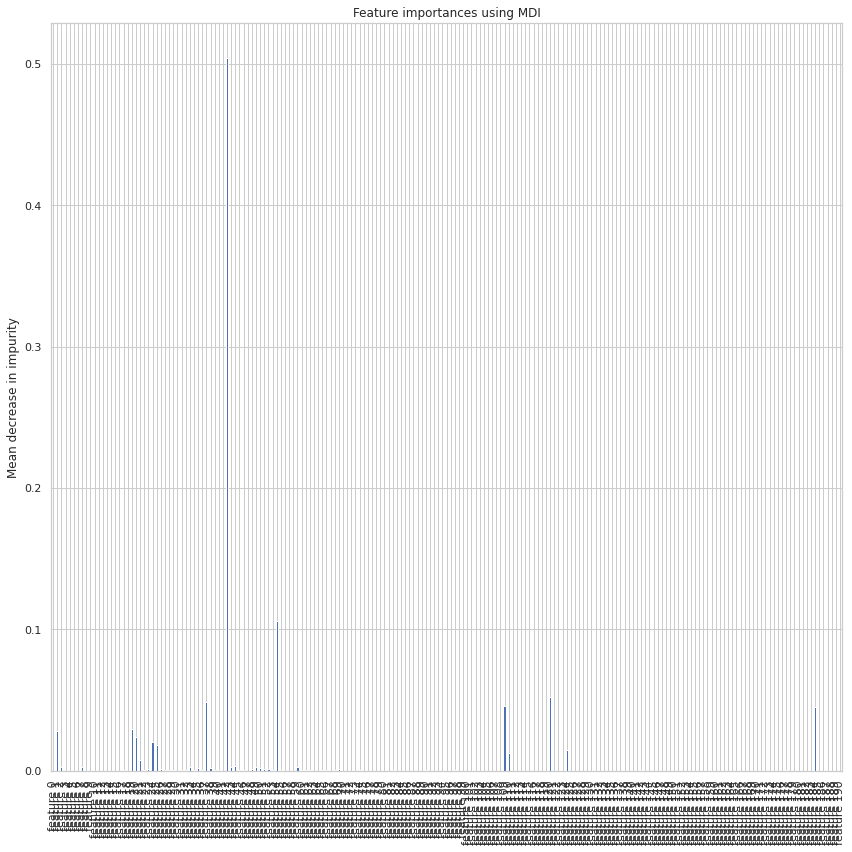

In [214]:
feature_names = [f"feature {i}" for i in range(X_new.shape[1])]
importances = rfc.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
std = np.std([rfc.feature_importances_ for tree in rfc.estimators_], axis=0)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [215]:
lin_reg.fit(X_train4, y_train4)
lin_reg.score(X_test4, y_test4)
cross_val_score(lin_reg,X_test4,y_test4, cv=5)

array([0.82809558, 0.82594449, 0.81020181, 0.80716314, 0.84596038])

## Final Modelling with GridSearch

xgboost (booster = 'gbtree')

In [216]:
xgb_tree = xgb.XGBRegressor()
xgb_lin = xgb.XGBRegressor(booster='gblinear')

In [217]:
xgb_tree.fit(X_train,y_train)
xgb_tree.score(X_test,y_test)

0.8087968786582754

In [218]:
xgb_lin.fit(X_train,y_train)
xgb_lin.score(X_test,y_test)

0.8665296903648599

In [ ]:
pipeline_xgb_tree = Pipeline(steps=[('ss', ss), ('xgb_tree', xgb_tree)])
hyperparameter_grid = {
    'xgb_tree__n_estimators': [100, 500, 900, 1100, 1500],
    'xgb_tree__max_depth': [2, 3, 5, 10, 15],
    'xgb_tree__learning_rate': [0.05, 0.1, 0.15, 0.20],
    'xgb_tree__min_child_weight': [1, 2, 3, 4]
    }
grid_search_xgb_tree=GridSearchCV(pipeline_xgb_tree,hyperparameter_grid, cv=5, n_jobs=-1)
grid_search_xgb_tree.fit(X_train, y_train)

In [ ]:
pipeline_xgb_tree = Pipeline(steps=[('ss', ss), ('xgb_tree', xgb_tree)])
hyperparameter_grid = {
    'xgb_tree__n_estimators': [10,25,50,100,150,200],
    'xgb_tree__max_depth': [2, 3, 5, 10, 15],
    'xgb_tree__learning_rate': [0.05, 0.1, 0.15, 0.20],
    'xgb_tree__min_child_weight': [1, 2, 3, 4]
    }
grid_search_xgb_tree=GridSearchCV(pipeline_xgb_tree,hyperparameter_grid, cv=5, n_jobs=-1)
grid_search_xgb_tree.fit(X_train, y_train)

In [ ]:
print(grid_search_xgb_tree.best_params_)
grid_search_xgb_tree.score(X_test, y_test)

In [ ]:
pipeline_xgb_tree = Pipeline(steps=[('ss', ss), ('xgb_tree', xgb_tree)])
hyperparameter_grid = {
    'xgb_tree__n_estimators': [10,25,50,100,150,200],
    'xgb_tree__max_depth': [2, 3, 5, 10, 15],
    'xgb_tree__learning_rate': [0.05, 0.1, 0.15, 0.20],
    'xgb_tree__min_child_weight': [1, 2, 3, 4]
    }
grid_search_xgb_tree=GridSearchCV(pipeline_xgb_tree,hyperparameter_grid, cv=5, n_jobs=-1)
grid_search_xgb_tree.fit(X_train, y_train)

{'xgb_tree__learning_rate': 0.1, 'xgb_tree__max_depth': 2, 'xgb_tree__min_child_weight': 2, 'xgb_tree__n_estimators': 100}
0.8672490170112312

xgboost (booster = 'gblinear')

In [ ]:
pipeline_xgb_lin = Pipeline(steps=[('ss', ss), ('xgb_lin', xgb_lin)])
hyperparameter_grid2 = {
    'xgb_lin__learning_rate': [0.05, 0.1, 0.15, 0.20],
    'xgb_lin__lambda': [0, 0.001, 0.1, 1, 5, 10],
    'xgb_lin__alpha': [0, 0.001, 0.1, 1, 5, 10],
    'xgb_lin__feature_selector': ['cyclic','shuffle']
    }
grid_search_xgb_lin=GridSearchCV(pipeline_xgb_lin,hyperparameter_grid2, cv=5, n_jobs=-1)
grid_search_xgb_lin.fit(X_train, y_train)



In [ ]:
print(grid_search_xgb_lin.best_params_)
grid_search_xgb_lin.score(X_test, y_test)

{'xgb_lin__alpha': 0.001, 'xgb_lin__feature_selector': 'cyclic', 'xgb_lin__lambda': 1, 'xgb_lin__learning_rate': 0.1} 0.8686125158017279

In [ ]:
xgb_lin2 = xgb.XGBRegressor(booster='gblinear', updater='coord_descent')
pipeline_xgb_lin2 = Pipeline(steps=[('ss', ss), ('xgb_lin2', xgb_lin2)])
hyperparameter_grid3 = {
    'xgb_lin2__learning_rate': [0.05, 0.1, 0.15, 0.20],
    'xgb_lin2__lambda': [0, 0.001, 0.1, 1, 5, 10],
    'xgb_lin2__alpha': [0, 0.001, 0.1, 1, 5, 10],
    'xgb_lin2__feature_selector': ['greedy','thrifty' ],
    'xgb_lin2__top_k': list(range(1,21,2))}
grid_search_xgb_lin2=GridSearchCV(pipeline_xgb_lin2,hyperparameter_grid3, cv=5, n_jobs=-1)
grid_search_xgb_lin2.fit(X_train, y_train)


{'xgb_lin2__alpha': 0, 'xgb_lin2__feature_selector': 'thrifty', 'xgb_lin2__lambda': 0.001, 'xgb_lin2__learning_rate': 0.1, 'xgb_lin2__top_k': 7} 0.8686335420613472


In [ ]:
print(grid_search_xgb_lin2.best_params_)
grid_search_xgb_lin2.score(X_test, y_test)

### Linear / Polynomial features 

In [219]:
from sklearn.linear_model import TweedieRegressor
tweedie=TweedieRegressor(power=0,alpha=0.05)
pipeline_tweedie=make_pipeline(ss,tweedie)
pipeline_tweedie.fit(X_train, y_train)
pipeline_tweedie.score(X_test,y_test)
rmse = np.sqrt(-cross_val_score(pipeline_tweedie, X, y, cv=5, scoring='neg_root_mean_squared_error'))
r2 = cross_val_score(pipeline_tweedie, X, y, cv=5, scoring='r2')
print (rmse.mean(), r2.mean())

67.01270559976744 0.8589689022982631


In [220]:
from sklearn.linear_model import HuberRegressor
huber=HuberRegressor(epsilon=1.35, alpha=0.000)
pipeline_huber=make_pipeline(ss,huber)
pipeline_huber.fit(X_train,y_train)
pipeline_huber.score(X_test,y_test)
rmse = np.sqrt(-cross_val_score(pipeline_huber, X, y, cv=5, scoring='neg_root_mean_squared_error'))
r2 = cross_val_score(pipeline_huber, X, y, cv=5, scoring='r2')
print (rmse.mean(), r2.mean())

67.91257556912434 0.850278002115507


In [221]:
from sklearn.preprocessing import PolynomialFeatures
pca2=PCA(n_components=0.98)
pol_features=PolynomialFeatures(degree=2, interaction_only=True)
pipeline_lin_reg=make_pipeline(pol_features,ss,pca2, lin_reg)
pipeline_lin_reg.fit(X_train,y_train)
pipeline_lin_reg.score(X_test,y_test)
rmse = np.sqrt(-cross_val_score(pipeline_lin_reg, X, y, cv=5, scoring='neg_root_mean_squared_error'))
r2 = cross_val_score(pipeline_lin_reg, X, y, cv=5, scoring='r2')
print (rmse.mean(), r2.mean())

67.24264764731178 0.8562025815019597


In [222]:
xgb_lin_final = xgb.XGBRegressor(booster='gblinear',alpha=0, feature_selector= 'greedy', reg_lambda = 0.001, learning_rate= 0.09, top_k= 7,updater='coord_descent')
pipeline_xgb_lin_final = make_pipeline(pol_features,ss, xgb_lin_final)
pipeline_xgb_lin_final.fit(X_train,y_train)
pipeline_xgb_lin_final.score(X_test,y_test)
y_pred=pipeline_xgb_lin_final.predict(X_test)
rmse = np.sqrt(-cross_val_score(pipeline_xgb_lin_final, X, y, cv=5, scoring='neg_root_mean_squared_error'))
r2 = cross_val_score(pipeline_xgb_lin_final, X, y, cv=5, scoring='r2')
print (rmse.mean(), r2.mean())

66.71534904320285 0.8612015269450332


In [223]:
from sklearn.metrics import r2_score

xgb_tree_final=xgb.XGBRegressor(learning_rate=0.13,max_depth=2,min_child_weight=3, n_estimators=100)
pipeline_xgb_tree_final = make_pipeline(ss, xgb_tree_final)
pipeline_xgb_tree_final.fit(X_train,y_train)
print(pipeline_xgb_tree_final.score(X_test,y_test))
rmse = np.sqrt(-cross_val_score(pipeline_xgb_tree_final, X, y, cv=5, scoring='neg_root_mean_squared_error'))
r2 = cross_val_score(pipeline_xgb_tree_final, X, y, cv=5, scoring='r2')
print (rmse.mean(), r2.mean())

0.8675191394786679
66.9405432629637 0.8597184670208853


In [224]:
stacking=StackingRegressor(estimators=[('tweedie', tweedie), ('xgb', xgb_lin_final)])
pipeline_stacking = make_pipeline(pol_features, ss, stacking)
pipeline_stacking.fit(X_train,y_train)
pipeline_stacking.score(X_test,y_test)
rmse = np.sqrt(-cross_val_score(pipeline_stacking, X, y, cv=5, scoring='neg_root_mean_squared_error'))
r2 = cross_val_score(pipeline_stacking, X, y, cv=5, scoring='r2')
print (rmse.mean(), r2.mean())

66.76811841265341 0.8607486205937136


In [225]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
from hyperopt.pyll.base import scope
from hyperopt.pyll.stochastic import sample

In [263]:
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

from xgboost import XGBRegressor


def run_xgb_hyperopt(X, y, cv, max_evals, random_state):
    
    # funkcja, której wynik chcemy minimalizować (RMSE)
    def objective(space):
        XGB_model = XGBRegressor(
            max_depth = int(space['max_depth']),
            n_estimators = int(space['n_estimators']),
            min_child_weight = space['min_child_weight'],
            subsample = space['subsample'],
            learning_rate = space['learning_rate'],
            gamma = space['gamma'],
            colsample_bytree = space['colsample_bytree'],
            random_state=random_state)
        for train_idx, test_idx in cv.split(X):
            eval_set = [(X.iloc[train_idx], y.iloc[train_idx]), (X.iloc[test_idx], y.iloc[test_idx])]
            XGB_model.fit(X.iloc[train_idx], y.iloc[train_idx], eval_set=eval_set, eval_metric = 'rmse', early_stopping_rounds=10, verbose=False)
            y_pred = XGB_model.predict(X.iloc[test_idx])

            rmse = np.sqrt(mean_squared_error(y.iloc[test_idx], y_pred))
            
            print("RMSE: {:.4f}".format(rmse))
            return{'loss': rmse, 'status': STATUS_OK }
    
    # parametry do optymizacji    
    space ={
            'max_depth': hp.choice('max_depth', np.arange(2, 4, 1, dtype=int)),
            'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
            'subsample': hp.uniform('subsample', 0.7, 1),
            'n_estimators' : hp.choice('n_estimators', np.arange(20, 150, 2, dtype=int)),
            'learning_rate' : hp.quniform('learning_rate', 0.025, 0.5, 0.025),
            'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
            'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05)
        }

    trials = Trials() # przechowuje info dla kazdego kroku.
    
    best = fmin(fn=objective, #fmin - funkcja, ktora chcemy minimalizowac
                space=space, #przestrzeń potencjalnych (hyper)parametrów
                algo=tpe.suggest, #algorytm wyszukujacy najlepsze parametry
                max_evals=max_evals, #ilość prób
                trials=trials) #zapisywane wynikow w trakcie
    
    hyperparams = space_eval(space, best)

    print("The best params: ", hyperparams)
    return hyperparams

In [ ]:
df2=(df-df.mean())/df.std()
y = df2['charges']
X = df2.drop('charges', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=X.smoker_yes)
best_XGB = run_xgb_hyperopt(X_train, y_train, cv=kf, max_evals=500, random_state=42)

In [265]:

XGB_model = XGBRegressor(**best_XGB, random_state=42)
XGB_model.fit(X_train,y_train)
score=XGB_model.score(X_test,y_test)
rmse = np.sqrt(-cross_val_score(XGB_model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error'))
r2 = cross_val_score(XGB_model, X_train, y_train, cv=5, scoring='r2')
print (score,rmse.mean(), r2.mean())

0.8544904170428009 0.6322696883029848 0.8328898166423769


In [241]:
XGB_model.fit(X_train,y_train)
XGB_model.score(X_test,y_test)

0.8592475594004229

In [251]:
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

from xgboost import XGBRegressor


def run_xgb_hyperopt2(X, y, cv, max_evals, random_state):
    
    # funkcja, której wynik chcemy minimalizować (RMSE)
    def objective(space):
        XGB_model = XGBRegressor(
            max_depth = int(space['max_depth']),
            n_estimators = int(space['n_estimators']),
            min_child_weight = space['min_child_weight'],
            subsample = space['subsample'],
            learning_rate = space['learning_rate'],
            gamma = space['gamma'],
            colsample_bytree = space['colsample_bytree'],
            random_state=random_state)
        for train_idx, test_idx in cv.split(X):
            eval_set = [(X.iloc[train_idx], y.iloc[train_idx]), (X.iloc[test_idx], y.iloc[test_idx])]
            XGB_model.fit(X.iloc[train_idx], y.iloc[train_idx], eval_set=eval_set, eval_metric = 'rmse', early_stopping_rounds=10, verbose=False)
            y_pred = XGB_model.predict(X.iloc[test_idx])

            r2 = -r2_score(y.iloc[test_idx], y_pred)
            
            print("r2: {:.4f}".format(-r2))
            return{'loss': r2, 'status': STATUS_OK }
    
    # parametry do optymizacji    
    space ={
            'max_depth': hp.choice('max_depth', np.arange(2, 4, 1, dtype=int)),
            'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
            'subsample': hp.uniform('subsample', 0.7, 1),
            'n_estimators' : hp.choice('n_estimators', np.arange(20, 150, 2, dtype=int)),
            'learning_rate' : hp.quniform('learning_rate', 0.025, 0.5, 0.025),
            'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
            'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05)
        }

    trials = Trials() # przechowuje info dla kazdego kroku.
    
    best = fmin(fn=objective, #fmin - funkcja, ktora chcemy minimalizowac
                space=space, #przestrzeń potencjalnych (hyper)parametrów
                algo=tpe.suggest, #algorytm wyszukujacy najlepsze parametry
                max_evals=max_evals, #ilość prób
                trials=trials) #zapisywane wynikow w trakcie
    
    hyperparams = space_eval(space, best)

    print("The best params: ", hyperparams)
    return hyperparams

In [ ]:
best_XGB2 = run_xgb_hyperopt2(X_train, y_train, cv=kf, max_evals=500, random_state=42)

In [262]:
#kf daje lepsze!
XGB_model2 = XGBRegressor(**best_XGB2, random_state=42)
XGB_model2.fit(X_train,y_train)
score=XGB_model2.score(X_test,y_test)
rmse = np.sqrt(-cross_val_score(XGB_model2, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error'))
r2 = cross_val_score(XGB_model2, X_train, y_train, cv=5, scoring='r2')
print (score,rmse.mean(), r2.mean())
cross_val_score(XGB_model2, X_train, y_train, cv=5, scoring='r2').mean()

0.8624291584910481 0.6129165085128768 0.8527137605127921


0.8527137605127921